In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
# Load the dataset
file_path = '/content/train.csv'
df = pd.read_csv('/content/train.csv')

In [3]:
rename_columns = {
    'Air temperature [K]': 'AirTemp',
    'Process temperature [K]': 'ProcessTemp',
    'Rotational speed [rpm]': 'RotSpeed',
    'Torque [Nm]': 'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure': 'MachineFailure'
}
df.rename(columns=rename_columns, inplace=True)

In [4]:
feature_columns = ['AirTemp', 'ProcessTemp', 'RotSpeed', 'Torque', 'ToolWear']
X = df[feature_columns]
y = df['MachineFailure']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
log_reg = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])
log_reg.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

In [7]:
y_prob_train = log_reg.predict_proba(X_train)[:, 1]
y_prob_test = log_reg.predict_proba(X_test)[:, 1]

In [8]:
print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, log_reg.predict(X_test)):.4f}")
print(classification_report(y_test, log_reg.predict(X_test)))

Logistic Regression Evaluation:
Accuracy: 0.9841
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     26848
           1       0.58      0.03      0.06       438

    accuracy                           0.98     27286
   macro avg       0.78      0.52      0.53     27286
weighted avg       0.98      0.98      0.98     27286



In [9]:
X_train_rfr = X_train.copy()
X_train_rfr['FailureProbability'] = y_prob_train
X_test_rfr = X_test.copy()
X_test_rfr['FailureProbability'] = y_prob_test

In [10]:
rul_target = df['ToolWear'].max() - df['ToolWear']

In [11]:
rul_train = rul_target.loc[X_train.index]
rul_test = rul_target.loc[X_test.index]

In [12]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train_rfr, rul_train)

RandomForestRegressor(random_state=42)

In [13]:
y_rul_pred = rfr.predict(X_test_rfr)

In [14]:
mse = mean_squared_error(rul_test, y_rul_pred)
r2 = r2_score(rul_test, y_rul_pred)
print("\nRandom Forest Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")


Random Forest Regression Evaluation:
Mean Squared Error (MSE): 0.0000
R-squared Score: 1.0000


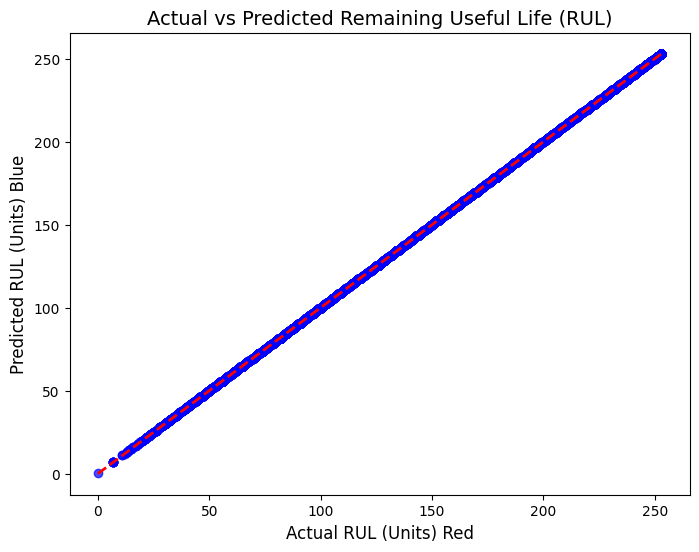

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(rul_test, y_rul_pred, alpha=0.7, color='blue')
plt.plot([rul_test.min(), rul_test.max()], [rul_test.min(), rul_test.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Remaining Useful Life (RUL)", fontsize=14)
plt.xlabel("Actual RUL (Units) Red", fontsize=12)
plt.ylabel("Predicted RUL (Units) Blue", fontsize=12)
plt.show()

In [20]:
print("\nEnter the machine's sensor metrics to predict failure and RUL:")
new_data = {
    'AirTemp': [float(input("Enter Air Temperature (K): "))],
    'ProcessTemp': [float(input("Enter Process Temperature (K): "))],
    'RotSpeed': [float(input("Enter Rotational Speed (rpm): "))],
    'Torque': [float(input("Enter Torque (Nm): "))],
    'ToolWear': [float(input("Enter Tool Wear (min): "))],
    }
new_data_df = pd.DataFrame(new_data)


Enter the machine's sensor metrics to predict failure and RUL:
Enter Air Temperature (K): 1000
Enter Process Temperature (K): 3456
Enter Rotational Speed (rpm): 2344
Enter Torque (Nm): 2300
Enter Tool Wear (min): 2500


In [21]:
new_failure_prob = log_reg.predict_proba(new_data_df)[0, 1]
new_data_df['FailureProbability'] = new_failure_prob

In [22]:
predicted_rul = rfr.predict(new_data_df)[0]

In [23]:
print(f"\n───────────────────────────────────────────────────────────────────────────────")
print(f"Failure Probability: {new_failure_prob:.4f}")
print(f"Predicted Remaining Useful Life (RUL): {predicted_rul:.2f} units")
if predicted_rul < 5:
    print("⚠️ Urgent Maintenance Alert: The machine may require immediate attention.")
elif predicted_rul < 15:
    print("⚠️ Maintenance Recommended: Schedule maintenance soon.")
else:
    print("✅ Maintenance Monitoring: The machine is in good condition.")
print(f"───────────────────────────────────────────────────────────────────────────────")


───────────────────────────────────────────────────────────────────────────────
Failure Probability: 0.0000
Predicted Remaining Useful Life (RUL): 1.24 units
⚠️ Urgent Maintenance Alert: The machine may require immediate attention.
───────────────────────────────────────────────────────────────────────────────
